In [1]:
from methods import *


edges read from csv-file.


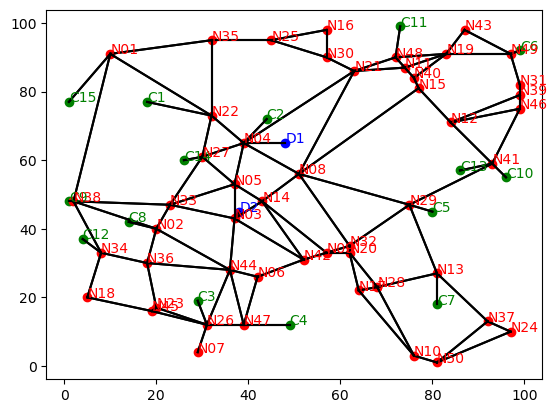

In [3]:
# plot network
for d in D.values():
    plt.scatter(d.coord.x, d.coord.y, c='b')
    plt.text(d.coord.x, d.coord.y, d.ID, c='b')
del d
for c in C.values():
    plt.scatter(c.coord.x, c.coord.y, c='g')
    plt.text(c.coord.x, c.coord.y, c.ID, c='g')
    del c
for n in N.values():
    plt.scatter(n.coord.x, n.coord.y, c='r')
    plt.text(n.coord.x, n.coord.y, n.ID, c='r')
del n
for (i, j) in E:
    plt.plot([V[i].coord.x, V[j].coord.x], [V[i].coord.y, V[j].coord.y], color='black')
del i, j
plt.show()


In [4]:
# find the shortest path between all customers/depots to reduce the size of the problem
shortest_distance_temp = dict()
predecessor_dijkstra = dict()
for i in V:
    shortest_distance_temp[i], predecessor_dijkstra[i] = dijkstra(Dist_graph, i)
del i
dist_dijkstra = {i: {j: shortest_distance_temp[i][j] for j in V} for i in shortest_distance_temp }
drive_times_dijkstra = calc_driving_time(dist_dijkstra)
del shortest_distance_temp
print('shortest distances calculated')

shortest distances calculated


In [ ]:
# allocate the customers to the closest depot
allocation = {d: [] for d in D}
for c in C:
    dist_depot = {d: dist_dijkstra[c][d] for d in D}
    d = min(dist_depot, key=dist_depot.get)
    allocation[d].append(c)
del c
print(allocation)
demand_depot = {d: sum([V[i].demand for i in allocation[d]]) for d in D}
del dist_depot

for c in C.values():
    plt.scatter(c.coord.x, c.coord.y, c='g')
    plt.text(c.coord.x, c.coord.y, c.ID, c='g')
del c
for d in D.values():
    plt.scatter(d.coord.x, d.coord.y, c='b')
    plt.text(d.coord.x, d.coord.y, d.ID, c='b')
    for c_id in allocation[d.ID]: # here is c just the id not the object itself
        plt.plot([d.coord.x, C[c_id].coord.x], [d.coord.y, C[c_id].coord.y], color='black')
    del c_id
del d
plt.show()


In [ ]:
# ---create initial routes with a savings heuristic--- #
initial_routes = []
max_route_ID = 0
for i in Visits:  # reset dict visits
    Visits[i] = dict()
del i
route_visited = dict()  # local dict to see on which route the nodes are, only works for the initial routes because nodes can be on several routes due to split delivery
list_route_keys = list(R.keys())
for k in list_route_keys:
    del R[k]
del list_route_keys

# create initial routes for each depot separately
for d in D:
    if len(initial_routes) > 0:
        max_route_ID = max([int(r.ID.replace('R','')) for r in initial_routes]) + 1
    # create a route for each customer
    # clear route dict, just in case if the cell is run a second time
    routes_depot = dict()

    for i in range(len(allocation[d])):
        route_id = f'R{(i +max_route_ID)}'
        routes_depot[route_id] = Route(_id=route_id, _tour=[d, allocation[d][i], d])
        route_visited[allocation[d][i]] = route_id
    del i


    #routes = {f'R{(i +max_route_ID)}': Route(_id=f'R{(i +max_route_ID)}', _nodes=[d, allocation[d][i], d]) for i in range(len(allocation[d]))} # routes at a depot, to be able to delete it later with the key
    for _, r in routes_depot.items():
        r.update_demand()
    del _, r

    nodes_at_depot = [d] + allocation[d].copy() # the depot and all customers allocated to it
    costs = {i: {j: dist_dijkstra[i][j] for j in nodes_at_depot if j!= i } for i in nodes_at_depot}  # all customers and the depot itself at this depot
    savings = {(i, j): (round(costs[i][d] + costs[d][j] - costs[i][j],2)) for j in allocation[d]  for i in allocation[d] if i != j}
    while len(savings) > 0:
        # find the biggest saving
        (n1,n2) = max(savings, key=savings.get)

        # update routes
        r1 = route_visited[n1]
        r2 = route_visited[n2]
        # r1 = list(visits[n1].keys())[0]
        # r2 = list(visits[n2].keys())[0]
        if routes_depot[r1].demand + routes_depot[r2].demand < Capacity_truck:
            pos1 = routes_depot[r1].main_tour.index(n1)
            pos2 = routes_depot[r2].main_tour.index(n2)
            # XOR operator, if NOT exactly one of the positions is 1, the second route has to be reversed
            if not ((pos1==1) ^ (pos2==1)):
                routes_depot[r2].main_tour.reverse()
            routes_depot[r1].main_tour =routes_depot[r1].main_tour[0:-1] + routes_depot[r2].main_tour[1:] # new combined route

            for n in routes_depot[r2].main_tour[0:-1]: # change the route of all nodes in r2 to r1
                route_visited[n] = r1
            del n
            del routes_depot[r2] # delete old route

            routes_depot[r1].update_demand()  # update demand of current node

            # update costs with the new routes
            costs[d][n2] = costs[d][n1] + costs[n1][n2]
            costs[n1][d] = costs[n1][n2] + costs[n2][d]

            # recalculate savings
            savings = dict()
            for r1 in routes_depot.values():
                #start and end node on current_tour
                current_nodes = (r1.main_tour[1], r1.main_tour[-2])
                for n1 in current_nodes:
                # find all start or end notes on the other routes from this depot
                    other_nodes = set()
                    for r2 in routes_depot.values():
                        if r1.ID != r2.ID:
                            other_nodes.add(r2.main_tour[1]) # add first customer on route to nodes with possible savings
                            other_nodes.add(r2.main_tour[-2]) # add last customer on route to nodes with possible savings
                    del r2
                    # calculate possible savings
                    for n2 in other_nodes:
                        savings[n1, n2] = round(costs[n1][d] + costs[d][n2] - costs[n1][n2], 2)
                    del n2
                del n1, other_nodes
            del r1
        else: # combined demand would be over the capacity of a truck, so not possible --> delete saving
            del savings[n1,n2]

    # no more savings in for this depot possible, save routes to final routes
    initial_routes = initial_routes + list(routes_depot.values())

    del savings, current_nodes
del d
# cant do dict comprehension, because it would create a new dict instead of changing the existing one, which is initialized in methods
for r in initial_routes:
    R[r.ID] = r
del initial_routes, r


for r in R.values():
    r.find_exact_tour()
del r

print(R)
#print(visits)




In [ ]:
# plot routes
for c in C.values():
    plt.scatter(c.coord.x, c.coord.y, c='g')
    plt.text(c.coord.x, c.coord.y, c.ID, c='g')
del c
for d in D.values():
    plt.scatter(d.coord.x, d.coord.y, c='b')
    plt.text(d.coord.x, d.coord.y, d.ID, c='b')
del d
for n in N.values():
    plt.scatter(n.coord.x, n.coord.y, c='r')
    plt.text(n.coord.x, n.coord.y, n.ID, c='r')
del n


for r in R.values():
    for i in range(len(r.exact_tour)-1):
        plt.plot([V[r.exact_tour[i]].coord.x, V[r.exact_tour[i+1]].coord.x], [V[r.exact_tour[i]].coord.y, V[r.exact_tour[i+1]].coord.y],
                 color=list(mcolors.TABLEAU_COLORS.values())[r.get_id_as_num()])
    del i
del r
plt.show()

In [ ]:
# create visits for the initial tours
for r in R:
    Visits_dict[r] = []
for r in R.values():
    cur_time = 0
    r.leaving_times = [None] * len(r.exact_tour)
    for v_ind in range(len(r.exact_tour)):
        cur_node = r.exact_tour[v_ind]
        cur_time += V[r.exact_tour[v_ind]].service_time  # update current time with service time of current node
        r.leaving_times[v_ind] = cur_time
        if v_ind == 0: # first node in tour
            cur_predecessor = None  # doesnt have a predecessor
        else:
            cur_predecessor = r.exact_tour[v_ind-1]
        if v_ind == len(r.exact_tour) - 1:  # last node in tour
            cur_successor = None  # doesnt have a successor
        else:
            cur_successor = r.exact_tour[v_ind +1]
        Visits_dict[r.ID].append(Visit(route=r.ID, node=cur_node, leave_time=cur_time, earliest_time=cur_time, predecessor=cur_predecessor, successor=cur_successor))
        if cur_successor is not None:  # if not last node in tour
            cur_time += Drive_time_graph[cur_node][cur_successor]

    del v_ind, cur_node, cur_time, cur_predecessor, cur_successor

    # calculate the latest times backwards
    cur_time = Visits_dict[r.ID][-1].latest_time
    for v_ind in range(len(Visits_dict[r.ID]) -1, -1 , -1):
        Visits_dict[r.ID][v_ind].latest_time = cur_time
        if v_ind > 0:  # if it's not the first node on the tour update cur_time with
            cur_time += - V[r.exact_tour[v_ind]].service_time  # service time
            cur_time += - Drive_time_graph[r.exact_tour[v_ind - 1]][r.exact_tour[v_ind]]  # driving time
    del v_ind
del r

print('Visits calculated')


In [ ]:
create_platoons()
print('First platoons created!')

In [ ]:
gene = create_gene_from_tours()
print(gene)

In [ ]:
gene.recreate_tour()
